## Heart Disease Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
df = pd.read_csv(url, header=None)
df.rename(columns={0:'Age', 1:'Sex', 2:'Cp', 3:'Trestbps', 4:'Chol', 5:'Fbs', 6:'Restecg',7:'Thalach',
                   8:'Exang',9:'Oldpeak', 10:'Slope', 11:'Ca', 12:'Thal',13:'Predict'},inplace=True)
df.head()

,Age,Sex,Cp,Trestbps,Chol,Fbs,Restecg,Thalach,Exang,Oldpeak,Slope,Ca,Thal,Predict
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Age       303 non-null    float64
 1   Sex       303 non-null    float64
 2   Cp        303 non-null    float64
 3   Trestbps  303 non-null    float64
 4   Chol      303 non-null    float64
 5   Fbs       303 non-null    float64
 6   Restecg   303 non-null    float64
 7   Thalach   303 non-null    float64
 8   Exang     303 non-null    float64
 9   Oldpeak   303 non-null    float64
 10  Slope     303 non-null    float64
 11  Ca        303 non-null    object 
 12  Thal      303 non-null    object 
 13  Predict   303 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 33.3+ KB


## Find the missing values

In [4]:
df.isin(['?']).any()

Age         False
Sex         False
Cp          False
Trestbps    False
Chol        False
Fbs         False
Restecg     False
Thalach     False
Exang       False
Oldpeak     False
Slope       False
Ca           True
Thal         True
Predict     False
dtype: bool

In [5]:
df[(df.Thal=='?') | (df.Ca=='?')]

,Age,Sex,Cp,Trestbps,Chol,Fbs,Restecg,Thalach,Exang,Oldpeak,Slope,Ca,Thal,Predict
87,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,0.0,?,0
166,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,?,3.0,0
192,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,?,7.0,1
266,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,?,2
287,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,?,7.0,0
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,0


In [6]:
df = df.replace('?', np.nan).dropna()

## Preprocessing

In [7]:
df.Predict.value_counts()

0    160
1     54
3     35
2     35
4     13
Name: Predict, dtype: int64

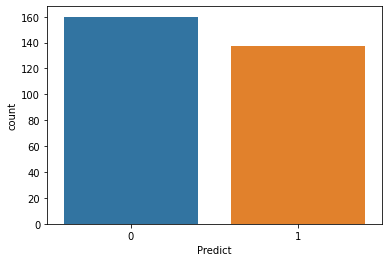

In [8]:
df.Predict.replace([1,2,3,4],1, inplace=True)
sns.countplot(data=df, x=df.Predict)

In [9]:
df[['Ca','Thal']] = df[['Ca','Thal']].astype('float')

## Spltting and formating the data

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Predict']), df.Predict,test_size=50)

In [11]:
Scaler = StandardScaler()
X_train = Scaler.fit_transform(X_train)
X_test = Scaler.transform(X_test)

In [12]:
X_train_tensor = torch.tensor(X_train).float()
X_test_tensor = torch.tensor(X_test).float()
y_train_tensor = torch.tensor(y_train.values).float()
y_test_tensor = torch.tensor(y_test.values).float()

print(X_train_tensor.shape)
print(y_train_tensor.shape)

y_train_tensor = y_train_tensor.reshape(-1,1)
y_test_tensor = y_test_tensor.reshape(-1,1)

print(y_train_tensor.shape)

torch.Size([247, 13])
torch.Size([247])
torch.Size([247, 1])


In [13]:
train_data = TensorDataset(X_train_tensor,y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

batchsize = 32
train_loader = DataLoader(train_data, batch_size=batchsize, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batchsize, drop_last=True)

## Creating ANN model

In [14]:
class ANN(nn.Module):
  def __init__(self):
    super().__init__()

    self.input = nn.Linear(13,32)

    self.hl1 = nn.Linear(32,64)
    self.hl2 = nn.Linear(64,10)

    self.output = nn.Linear(10,1)

  def forward(self,x):
    x = F.relu(self.input(x))
    x = F.relu(self.hl1(x))
    x = F.relu(self.hl2(x))
    return self.output(x)

In [15]:
model = ANN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss = nn.BCEWithLogitsLoss()

epochs = 120

train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)
train_accuracy = torch.zeros(epochs)
test_accuracy = torch.zeros(epochs)

In [16]:
for i in range(epochs):
  batch_loss = []
  for X,y in train_loader:
    y_predict = model(X)
    losses = loss(y_predict,y)
    
    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

    batch_loss.append(losses.item())

    predictions = (torch.sigmoid(y_predict)>0.5).float()
    train_accuracy[i] = accuracy_score(predictions,y)

  train_loss[i] = np.mean(batch_loss) 

  print("epoch:", i , "loss", losses.item())

  X,y = next(iter(test_loader))
  y_predict_test = model(X)

  losses_test = loss(y_predict_test,y)
  test_loss[i] = losses_test.item()

  predictions_test = (torch.sigmoid(y_predict_test)>0.5).float()
  test_accuracy[i] = accuracy_score(predictions_test,y)

epoch: 0 loss 0.6954283118247986
epoch: 1 loss 0.6944830417633057
epoch: 2 loss 0.6935595870018005
epoch: 3 loss 0.6927258372306824
epoch: 4 loss 0.6920084953308105
epoch: 5 loss 0.6913003921508789
epoch: 6 loss 0.6905498504638672
epoch: 7 loss 0.6897618770599365
epoch: 8 loss 0.6889257431030273
epoch: 9 loss 0.6880244016647339
epoch: 10 loss 0.6870709657669067
epoch: 11 loss 0.6860587000846863
epoch: 12 loss 0.6849796772003174
epoch: 13 loss 0.6838107705116272
epoch: 14 loss 0.6825442314147949
epoch: 15 loss 0.6812049746513367
epoch: 16 loss 0.6797938942909241
epoch: 17 loss 0.6782867908477783
epoch: 18 loss 0.6766534447669983
epoch: 19 loss 0.6748594641685486
epoch: 20 loss 0.6729536056518555
epoch: 21 loss 0.6708025932312012
epoch: 22 loss 0.6684364676475525
epoch: 23 loss 0.6657217144966125
epoch: 24 loss 0.6627339720726013
epoch: 25 loss 0.6594473123550415
epoch: 26 loss 0.6558830142021179
epoch: 27 loss 0.6521586179733276
epoch: 28 loss 0.6481679081916809
epoch: 29 loss 0.6438542

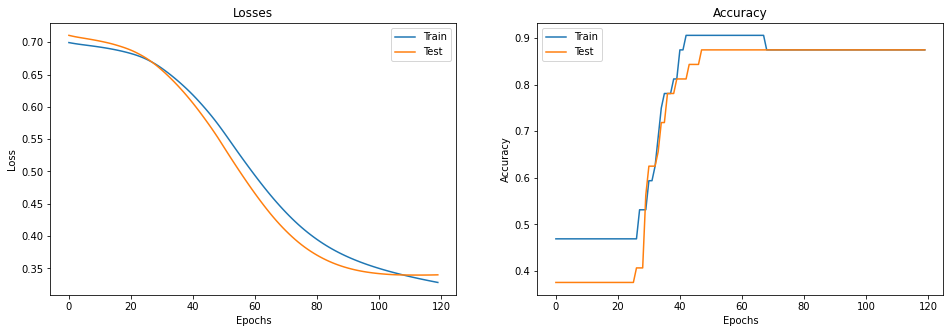

In [17]:
fig, ax = plt.subplots(1,2, figsize=(16,5))
ax[0].plot(train_loss, label = 'Train')
ax[0].plot(test_loss, label = 'Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Losses')
ax[0].legend()

ax[1].plot(train_accuracy, label = 'Train')
ax[1].plot(test_accuracy, label = 'Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()

In [18]:
print(int(100*test_accuracy[-1]))

87
